In [107]:
%pip install pymongo pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


Baue die Verbindung zur MongoDB auf:

In [129]:
from pymongo import MongoClient

# after that
#we make connection to our MongoDB Database
user = "root" # - your login
password = "BigDataAnalysisDatabase" # - your password 
host = "eeriefoods.de" # - it's ip address , where database is located 
port = 27017 # standart port
database = 'BDA' # name of your database's

# make our connection
client = MongoClient(f'mongodb://{user}:{password}@{host}:{port}/') #url and port where located your Mong

# Use our database
db = client['BDA']

print("database connected")

database connected
dokument aus DB geladen


Lade die historischen täglichen Ölpreise aus der Datenbank:

In [ ]:
for document in db["OilPricesDaily"].find():
    print("dokument aus DB geladen")

Ersetze fehlende Werte in historischen Öldaten durch Werte vom Vortag:

In [110]:
import pandas as pd

# Variablendefinition
seperator = '    '
last_value = 0
corrected_Oildata = document['data']

print('Geänderte Datensätze:')
print('Datum      Alter Wert  Neuer Wert')

# ersetze fehlende Daten durch Wert am Vortag
for i in reversed(range(len(corrected_Oildata))):
    if corrected_Oildata[i]['value'] == '.':
        print (corrected_Oildata[i]['date'],seperator,corrected_Oildata[i]['value'],seperator,last_value)
        corrected_Oildata[i]['value'] = last_value
        
    last_value = corrected_Oildata[i]['value']


# erzeuge DataFrame für korrigierte Öldaten
dfOil = pd.DataFrame(corrected_Oildata)
dfOil['date'] = pd.to_datetime(dfOil['date'])
dfOil = dfOil.apply(pd.to_numeric)
dfOil['date'] = pd.to_datetime(dfOil['date'])

print('DataFrame erzeugt')
print(dfOil)

Geänderte Datensätze:
Datum      Alter Wert  Neuer Wert
1987-06-15      .      18.78
1987-12-25      .      17.10
1988-01-01      .      17.60
1988-01-07      .      17.90
1988-01-26      .      16.45
1988-04-01      .      15.65
1988-04-04      .      15.65
1988-12-26      .      15.38
1989-01-02      .      16.23
1989-03-24      .      19.93
1989-03-27      .      19.93
1989-05-01      .      20.15
1989-12-25      .      20.50
1989-12-26      .      20.50
1990-01-01      .      21.05
1990-04-13      .      15.80
1990-04-16      .      15.80
1990-05-28      .      15.95
1990-12-25      .      27.70
1991-01-01      .      28.35
1991-03-29      .      18.00
1991-05-27      .      18.83
1991-12-25      .      17.78
1992-01-01      .      17.75
1992-04-17      .      18.95
1992-05-25      .      19.58
1992-12-25      .      18.28
1992-12-28      .      18.28
1993-01-01      .      17.85
1993-02-03      .      18.40
1993-04-09      .      18.53
1993-04-12      .      18.53
1993-05-03      

Lade historische Tankdaten aus Tankpreise_ADAC.csv:

In [111]:
# lade Tankdaten aus CSV-Datei
gas_prices = pd.read_csv('Tankpreise_ADAC.csv',sep = ';')


# rechne alte Werte in DM in EUR um
i=0
while gas_prices['Datum'][i][6:] < '2002':
    gas_prices['Diesel'][i] = gas_prices['Diesel'][i] / 1.95583
    gas_prices['Benzin'][i] = gas_prices['Benzin'][i] / 1.95583
    i = i+1

# erzeuge DataFrame für Tankdaten
dfGas = pd.DataFrame(gas_prices)
dfGas['Datum'] = pd.to_datetime(dfGas['Datum'],dayfirst=True)

print('DataFrame:')
print(dfGas)

DataFrame:
         Datum      Diesel      Benzin
0   1987-06-30   46.732078   48.470470
1   1988-06-30   45.147073   46.936595
2   1989-06-30   48.572729   55.986461
3   1990-06-30   51.998384   58.031629
4   1991-06-30   54.605973   65.036327
..         ...         ...         ...
295 2023-07-15  164.100000  180.500000
296 2023-08-15  176.600000  186.000000
297 2023-09-15  183.200000  188.400000
298 2023-10-15  181.900000  181.300000
299 2023-11-15  176.000000  176.100000

[300 rows x 3 columns]


C:\Users\jay31\AppData\Local\Temp\ipykernel_91184\396381220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_prices['Diesel'][i] = gas_prices['Diesel'][i] / 1.95583
C:\Users\jay31\AppData\Local\Temp\ipykernel_91184\396381220.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_prices['Benzin'][i] = gas_prices['Benzin'][i] / 1.95583
C:\Users\jay31\AppData\Local\Temp\ipykernel_91184\396381220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Zeichne Graph mit Ölpreisen und Tankpreisen seit 1987:

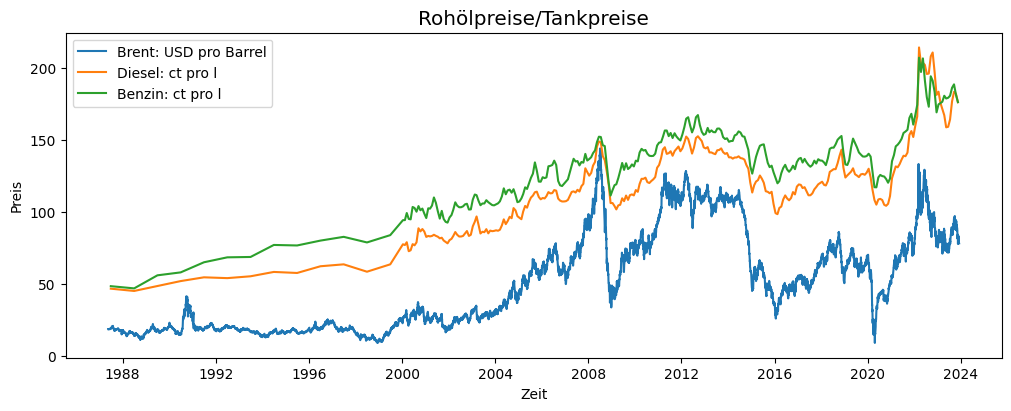

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

# Achsenbeschriftung für plot
plt.title("Rohölpreise/Tankpreise", size="x-large")
plt.ylabel("Preis")
plt.xlabel("Zeit")

# erzeuge plot
plt.plot(dfOil['date'],dfOil['value'],label='Brent: USD pro Barrel')
plt.plot(dfGas['Datum'],dfGas['Diesel'],label='Diesel: ct pro l')
plt.plot(dfGas['Datum'],dfGas['Benzin'],label='Benzin: ct pro l')

plt.legend()

plt.show()


Zeichne Graph mit Ölpreisen und Tankpreisen für die letzten x-Jahre:
Bearbeite hierfür die Variable "years"

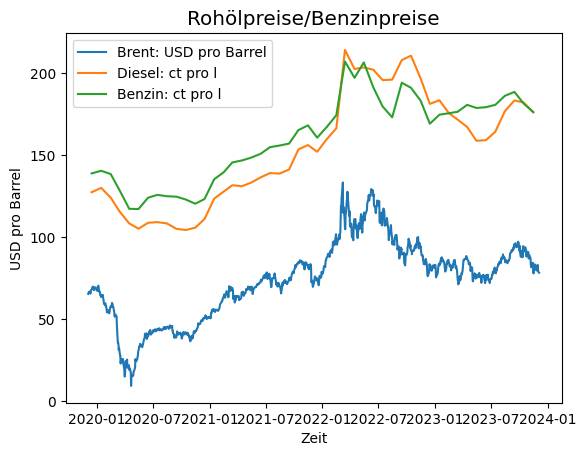

In [113]:
# Gib die Anzhal der Jahre ein
years = 4   # max 36


# rechne Jahre in Werktage und Monate um
days = years * 261

if years <= 24:
    month = years * 12
else:
    month = 24*12+(years-24)


# spiegele Arrays für Öldaten --> alte Daten müssen zuerst in Array stehen, wie bei dfGas
oil_date = dfOil['date'][::-1]
oil_price = dfOil['value'][::-1]


# Achsenbeschriftung für plot
plt.title("Rohölpreise/Benzinpreise", size="x-large")
plt.ylabel("USD pro Barrel")
plt.xlabel("Zeit")

# erzeuge plot
plt.plot(oil_date[-days:],oil_price[-days:],label='Brent: USD pro Barrel')
plt.plot(dfGas['Datum'][-month:],dfGas['Diesel'][-month:],label='Diesel: ct pro l')
plt.plot(dfGas['Datum'][-month:],dfGas['Benzin'][-month:],label='Benzin: ct pro l')

plt.legend()

plt.show()


Historische Öldaten werden nach Monaten gruppiert und es wird der Durchschnitt pro Monat gebildet.
Dies ist eine Vorarbeit für die Berechnung der Korrelation zwichen Ölpreisen und Tankpreisen.
Die Ölpreise müssen für die Berechnung der Korrelation monatsweise vorliegen, da die Tankpreise ebenfalls nur monatlich erfasst wurden.

In [114]:
# gruppiere Öldaten nach Jahren/Monaten
groupedOil= dfOil.groupby(dfOil.date.dt.to_period("M"))

#bilde Durchschnittswert pro Monat
averageOil = groupedOil['value'].mean()
averageOil

date
1987-05    18.580000
1987-06    18.856818
1987-07    19.856522
1987-08    18.979524
1987-09    18.313182
             ...    
2023-08    86.116087
2023-09    93.722381
2023-10    90.595909
2023-11    82.940000
2023-12    78.440000
Freq: M, Name: value, Length: 440, dtype: float64

Berechne den Korrelationkoeffizienten für Rohöl und Diesel seit 1987:

In [115]:
import numpy as np
# Korrelation Diesel

# Anzahl der Jahre, welche für Korrelation berücksichtigt werden
years = 24      # max 24

month = years * 12

# berechne Korrelationskoeffizienten
coef = np.corrcoef(averageOil[-month:], gas_prices['Diesel'][-month:])[0,1]

print('Korrelationskoeffizient: ',coef)

Korrelationskoeffizient:  0.7960867632429072


Berechne den Korrelationkoeffizienten für Rohöl und Benzin seit 1987:

In [116]:
# Korrelation Benzin

# Anzahl der Jahre, welche für Korrelation berücksichtigt werden
years = 24      # max 24

month = years * 12

# berechne Korrelationskoeffizienten
coef = np.corrcoef(averageOil[-month:], gas_prices['Benzin'][-month:])[0,1]

print('Korrelationskoeffizient: ',coef)

Korrelationskoeffizient:  0.8144259708277352


Stelle die Korrelationskoeffizienten für Rohöl/Diesel und für Rohöl/Benzin als zeitlichen Verlauf dar:

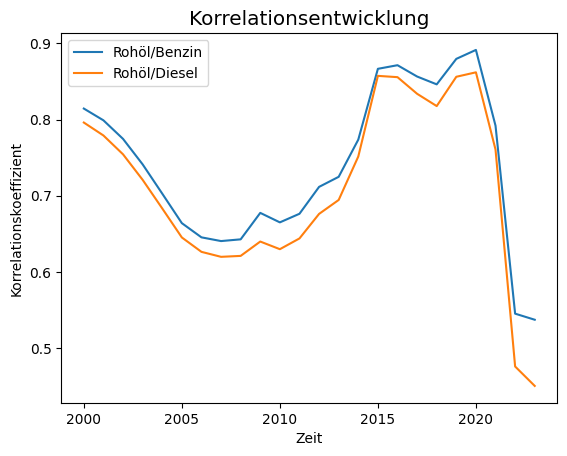

In [127]:
import datetime

year = []
coefDiesel = []
coefGas = []
month = 12

today = datetime.datetime.now().date()
currentYear = int(today.strftime('%Y'))

# kummuliert
for i in range(currentYear,1999,-1):
    year.append(i)
    coefVar = np.corrcoef(averageOil[-month:], gas_prices['Benzin'][-month:])[0,1]
    coefGas.append(coefVar)
    coefVar = np.corrcoef(averageOil[-month:], gas_prices['Diesel'][-month:])[0,1]
    coefDiesel.append(coefVar)
    month = month + 12


# Achsenbeschriftung für plot
plt.title("Korrelationsentwicklung", size="x-large")
plt.ylabel("Korrelationskoeffizient")
plt.xlabel("Zeit")

# erzeuge plot
plt.plot(year,coefGas,label='Rohöl/Benzin')
plt.plot(year,coefDiesel,label='Rohöl/Diesel')

plt.legend()

plt.show()
  


Lade die Tankdaten der Tankerkönig API aus der MongoDB:

In [118]:
from datetime import datetime

avg_diesel = []
avg_benzin = []
gas_date = []

for document in db["tankerkoenig"].find():
    gas_date.append(pd.to_datetime(datetime.utcfromtimestamp(document['time']).strftime('%Y-%m-%d %H:%M:%S')))
    avg_diesel.append(document['avg_diesel'])
    avg_benzin.append(document['avg_e10'])


Stelle die Tankdaten der Tankerkönig API graphisch dar:

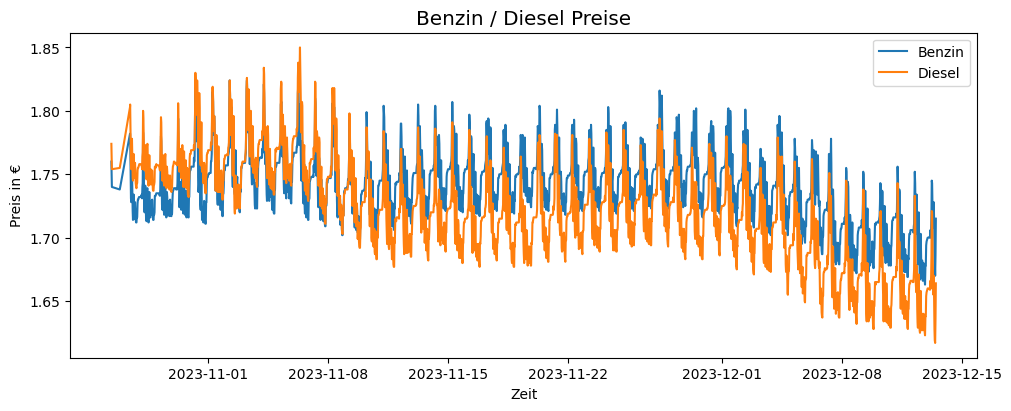

In [119]:
fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

plt.title("Benzin / Diesel Preise", size="x-large")
plt.ylabel("Preis in €")
plt.xlabel("Zeit")

plt.plot(gas_date,avg_benzin,label='Benzin')
plt.plot(gas_date,avg_diesel,label='Diesel')
    
plt.legend()

plt.show()

Lade die 5-minütlich erfassten Rohöldaten aus der MongoDB:

In [128]:

#Variablendefinition
oil_data = []
time_keys = []

#Alle Dokumente der Collection durchlaufen
for document in db["OilPrices"].find():
    time_keys = list(document["Time Series (5min)"].keys())

    # Alle Time keys des Dokuments durchlaufen und in Array schreiben
    for time_key in time_keys:
        oil_data.append([pd.to_datetime(time_key),pd.to_numeric(document["Time Series (5min)"][time_key]["4. close"])])

#nach Datum und Uhrzeit sortieren
oil_data.sort(key=lambda x: x[0])


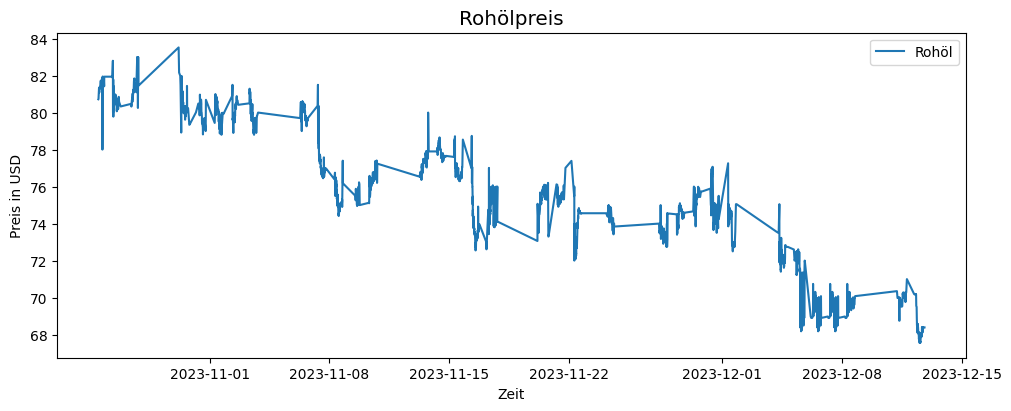

In [121]:
# Achsenbeschriftung für plot

oil_date = []
oil_price = []

for i in range(len(oil_data)):
    oil_date.append(oil_data[i][0])
    oil_price.append(oil_data[i][1])

fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

plt.title("Rohölpreis", size="x-large")
plt.ylabel("Preis in USD")
plt.xlabel("Zeit")

# erzeuge plot
plt.plot(oil_date,oil_price,label='Rohöl')


plt.legend()

plt.show()


Bearbeite Rohölpreise und Tankpreise:
- bei Tankpreisen den Steueranteil (laut https://www.mobil.org/sprit-steuerrechner-co2-steuer/) rausrechnen
- Rohölpreisen von Barrel auf Liter umrechnen
- Rohölpreisen von USD auf EUR umrechnen

In [122]:
USD_TO_EUR = 1.08
DIESEL_TAX = 0.5193
BENZIN_TAX = 0.4205
BARREL_TO_LITER = 159

avg_diesel_net = avg_diesel.copy()
avg_benzin_net = avg_benzin.copy()
oil_price_lit = oil_price.copy()


# Bei Tankpreisen den Steueranteil rausrechnen:
for i in range(len(avg_diesel)):
    # für Diesel 48.07% abziehen
    avg_diesel_net[i] = avg_diesel[i] * DIESEL_TAX
    
    # für Benzin 57.95% abziehen
    avg_benzin_net[i] = avg_benzin[i] * BENZIN_TAX

# Rohölpreise von Barrel auf Liter und von USD auf EUR umrechnen
for i in range(len(oil_price)):
    oil_price_lit[i] = (oil_price[i] / BARREL_TO_LITER) / USD_TO_EUR


Stelle bearbeitete Rohölpreise und Tankpreise graphisch dar:

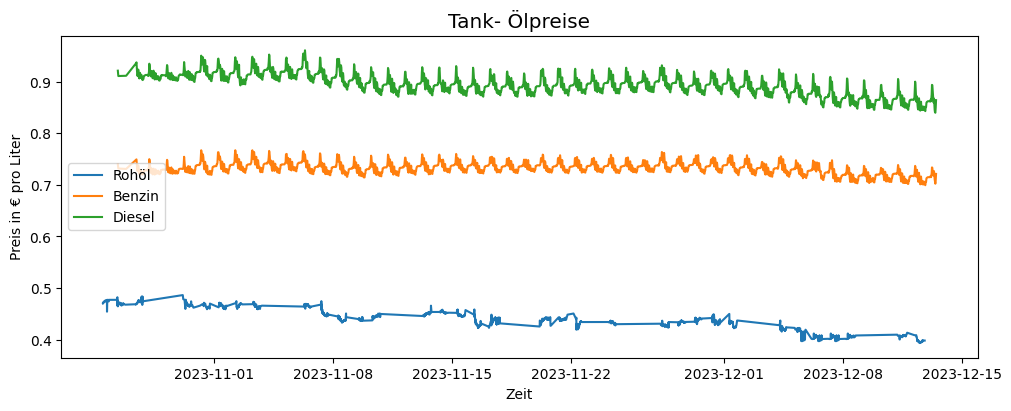

In [123]:
fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")

plt.title("Tank- Ölpreise", size="x-large")
plt.ylabel("Preis in € pro Liter")
plt.xlabel("Zeit")

plt.plot(oil_date,oil_price_lit,label='Rohöl')
plt.plot(gas_date,avg_benzin_net,label='Benzin')
plt.plot(gas_date,avg_diesel_net,label='Diesel')
    
plt.legend()

plt.show()

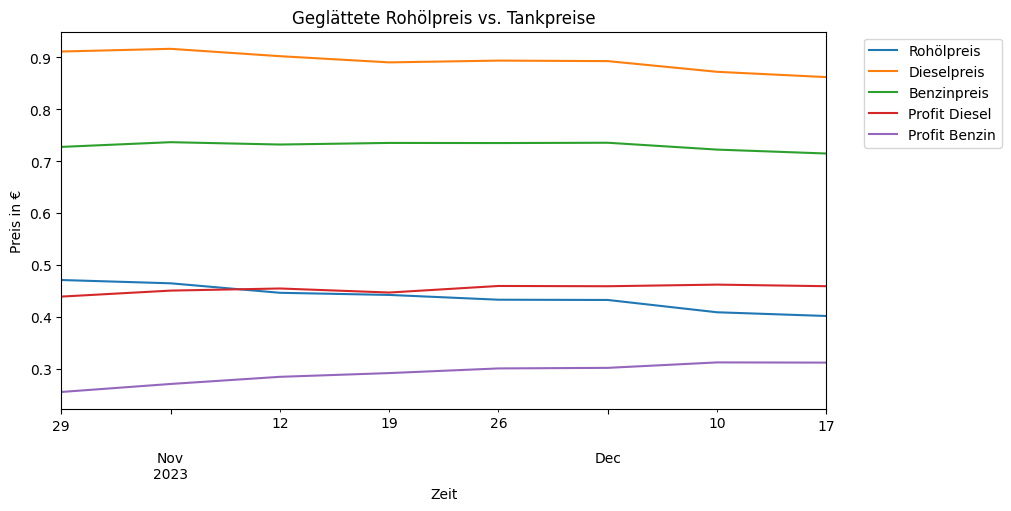

In [124]:
fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")


data_oil = pd.Series(data=oil_price_lit, index=oil_date)
data_diesel = pd.Series(data=avg_diesel_net, index=gas_date)
data_benzin = pd.Series(data=avg_benzin_net, index=gas_date)

RESAMPLE = 'W'

oil_resampled = data_oil.resample(RESAMPLE).mean()
diesel_resampeled = data_diesel.resample(RESAMPLE).mean()
benzin_resampeled = data_benzin.resample(RESAMPLE).mean()

diesel_diff = np.subtract(diesel_resampeled,oil_resampled)
benzin_diff = np.subtract(benzin_resampeled,oil_resampled)

oil_resampled.plot(label="Rohölpreis", title="Geglättete Rohölpreis vs. Tankpreise")
diesel_resampeled.plot(label="Dieselpreis", xlabel="Zeit", ylabel="Preis in €")
benzin_resampeled.plot(label="Benzinpreis")
diesel_diff.plot(label="Profit Diesel")
benzin_diff.plot(label="Profit Benzin")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()



### Durchschnittswert der Differenz berechnen

In [125]:
avg_benzin = np.average(benzin_diff)
print(f"Benzin: {avg_benzin:.4f} € pro Liter")
avg_diesel = np.average(diesel_diff)
print(f"Diesel: {avg_diesel:.4f} € pro Liter")

Benzin: 0.2919 € pro Liter
Diesel: 0.4545 € pro Liter
